# CNN Speaker Recognition using Keras/TensorFlow
## Advanced ML Final Part 1
### By: Daniel Hill

#### Business Use Case:
This project is part of a MS in Business Analytics program. The intention of this assignment is to be applied to a business use case. For the business use case for Part 1 of my final, I will be setting up the following fake scenario:

A business has begun implementing a new system for recording meetings in light of the advances in AI. They are using a transcription tool after getting the recordings, and then feeding this through an LLM to give them a summary of the meeting. The next step of their AI meeting recording is that they would like to know who is speaking at what time. The company has recorded each of their employees saying 20 phrases. The first 10 phrases are all the same, and the second 10 are all different. The company would like to see if they can build a model on the 10 phrases that are the same to successfully identify the speaker in the second 10 phrases. 

#### This Notebook:

I will be reimplementing the code here: [Keras Speaker Recognition Example](https://keras.io/examples/audio/speaker_recognition_using_cnn/).

I'm using a different dataset. The dataset I'm using can be obtained here: [Voice-Based Human Identity Recognition Dataset](https://data.mendeley.com/datasets/zw4p4p7sdh/1).

Uncomment the following cell to install required packages:

In [1]:
# Uncomment to install the required packages:
# !pip install -r requirements.txt

In [5]:
# Uncomment to download the dataset
# !curl -O https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/zw4p4p7sdh-1.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  959M  100  959M    0     0   359k      0  0:45:33  0:45:33 --:--:--  434k0:00:05  1:37:35  185k0     0   324k      0  0:50:26  0:00:20  0:50:06  381k02k      0  0:54:13  0:00:28  0:53:45  190k    0   298k      0  0:54:49  0:00:33  0:54:16  279k   2 21.6M    0     0   338k      0  0:48:25  0:01:05  0:47:20  333k6M    0     0   342k      0  0:47:46  0:01:16  0:46:30  376k     0   349k      0  0:46:51  0:01:23  0:45:28  434k 0     0   352k      0  0:46:28  0:01:35  0:44:53  396k 355k      0  0:46:07  0:01:54  0:44:13  325k6  0:01:56  0:44:10  303k357k      0  0:45:50  0:02:53  0:42:57  418k  357k      0  0:45:52  0:03:03  0:42:49  369k  0   356k      0  0:45:56  0:03:06  0:42:50  343k8k      0  0:45:40  0:03:28  0:42:12  380k8k      0  0:45:43  0:03:31  0:42:12  347kM    0     0   359k      0  0:45:36  0:03:36  0:42:00  404k0   

In [9]:
# Uncomment to rename the zipped file
# !mv zw4p4p7sdh-1.zip AudioData.zip

In [10]:
# Uncomment to unzip the dataset after you download
# !unzip -qq AudioData.zip

In [134]:
# imports
import os
import shutil
import io
import subprocess

import numpy as np
import setuptools as _setuptools
import tensorflow as tf
import keras
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

from pathlib import Path
from IPython.display import display, Audio
from pydub import AudioSegment
import soundfile as sf
import matplotlib.pyplot as plt

In the voice recognition dataset, they have a folder storing noise. Additionally, they have one repository of speaker data and they do a train-test split within that. I will be modifying this approach slightly.

## Setup

In [135]:
# Define global variables

TRAIN_DATA_FOLDER = "AudioData/samePhrase"
TEST_DATA_FOLDER = "AudioData/differentPhrase"

# This was set to 16000 because there are 16000 samples in the
# example's dataset. This should be changed to the number of samples?
SAMPLING_RATE = 16000

# Seed to use when shuffling the dataset
SHUFFLE_SEED = 43

# Set batch size for
BATCH_SIZE = 128

# Set epochs for model training
EPOCHS = 1

## Dataset Generation

In [115]:
# Step 1: Convert .flac to .wav
def convert_flac_to_wav(input_flac, output_wav):
    output_dir = os.path.dirname(output_wav)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    audio = AudioSegment.from_file(input_flac, format="flac")
    audio = audio.set_sample_width(2)  # Set sample width to 2 bytes (16 bits)
    audio.export(output_wav, format="wav")

In [116]:
final_folder = "AudioData"
parent_folder = "A Dataset for Voice-Based Human Identity Recognition"
for folder in os.listdir(parent_folder):
    if folder != "speakers.csv":
        sub_path = os.path.join(parent_folder, folder)
        for subfolder in os.listdir(sub_path):
            full_path = os.path.join(sub_path, subfolder)
            for file in os.listdir(full_path):
                path_with_file = os.path.join(full_path, file)
                final_file_name = file.split(".")[0]+".wav"
                convert_flac_to_wav(path_with_file, os.path.join(final_folder, folder, subfolder, final_file_name))

In [117]:
def path_to_audio(path):
    """Reads and decodes an audio file."""
    audio = tf.io.read_file(path)
    audio, _ = tf.audio.decode_wav(audio, 1, SAMPLING_RATE)
    return audio

In [118]:
def paths_and_labels_to_dataset(audio_paths, labels):
    """Constructs a dataset of audios and labels."""
    path_ds = tf.data.Dataset.from_tensor_slices(audio_paths)
    audio_ds = path_ds.map(
        lambda x: path_to_audio(x), num_parallel_calls=tf.data.AUTOTUNE
    )
    label_ds = tf.data.Dataset.from_tensor_slices(labels)
    return tf.data.Dataset.zip((audio_ds, label_ds))

In [119]:
def audio_to_fft(audio):
    # Since tf.signal.fft applies FFT on the innermost dimension,
    # we need to squeeze the dimensions and then expand them again
    # after FFT
    audio = tf.squeeze(audio, axis=-1)
    fft = tf.signal.fft(
        tf.cast(tf.complex(real=audio, imag=tf.zeros_like(audio)), tf.complex64)
    )
    fft = tf.expand_dims(fft, axis=-1)

    # Return the absolute value of the first half of the FFT
    # which represents the positive frequencies
    return tf.math.abs(fft[:, : (audio.shape[1] // 2), :])

In [120]:
train_class_names = os.listdir(TRAIN_DATA_FOLDER)
print(
    "Train class names: {}".format(
        train_class_names,
    )
)

Train class names: ['135', '61', '95', '132', '59', '92', '66', '104', '50', '68', '103', '57', '150', '32', '35', '102', '69', '56', '105', '51', '58', '133', '67', '93', '134', '94', '60', '34', '33', '20', '18', '27', '9', '145', '11', '142', '7', '29', '16', '129', '42', '89', '116', '45', '111', '73', '118', '87', '127', '80', '74', '120', '6', '28', '143', '17', '144', '1', '10', '19', '26', '8', '21', '75', '81', '121', '119', '86', '72', '126', '44', '110', '43', '128', '88', '117', '38', '36', '31', '131', '91', '65', '136', '62', '96', '109', '100', '54', '107', '98', '138', '53', '30', '37', '39', '106', '99', '52', '139', '101', '55', '137', '97', '108', '63', '130', '64', '90', '46', '79', '112', '41', '115', '83', '77', '123', '48', '70', '84', '124', '24', '148', '23', '141', '4', '15', '3', '146', '12', '85', '71', '125', '76', '82', '49', '122', '40', '114', '47', '113', '78', '147', '2', '13', '5', '140', '14', '22', '149', '25']


In [121]:
# Get all labels and process the audio

train_audio_paths = []
train_labels = []
for label, name in enumerate(train_class_names):
    print(
        "Processing speaker {}".format(
            name,
        )
    )
    dir_path = Path(TRAIN_DATA_FOLDER) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    train_audio_paths += speaker_sample_paths
    train_labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(train_audio_paths), len(train_labels))
)


Processing speaker 135
Processing speaker 61
Processing speaker 95
Processing speaker 132
Processing speaker 59
Processing speaker 92
Processing speaker 66
Processing speaker 104
Processing speaker 50
Processing speaker 68
Processing speaker 103
Processing speaker 57
Processing speaker 150
Processing speaker 32
Processing speaker 35
Processing speaker 102
Processing speaker 69
Processing speaker 56
Processing speaker 105
Processing speaker 51
Processing speaker 58
Processing speaker 133
Processing speaker 67
Processing speaker 93
Processing speaker 134
Processing speaker 94
Processing speaker 60
Processing speaker 34
Processing speaker 33
Processing speaker 20
Processing speaker 18
Processing speaker 27
Processing speaker 9
Processing speaker 145
Processing speaker 11
Processing speaker 142
Processing speaker 7
Processing speaker 29
Processing speaker 16
Processing speaker 129
Processing speaker 42
Processing speaker 89
Processing speaker 116
Processing speaker 45
Processing speaker 11

In [122]:
# Get all testing labels and process the audio

test_audio_paths = []
test_labels = []
for label, name in enumerate(train_class_names):
    print(
        "Processing speaker {}".format(
            name,
        )
    )
    dir_path = Path(TEST_DATA_FOLDER) / name
    speaker_sample_paths = [
        os.path.join(dir_path, filepath)
        for filepath in os.listdir(dir_path)
        if filepath.endswith(".wav")
    ]
    test_audio_paths += speaker_sample_paths
    test_labels += [label] * len(speaker_sample_paths)

print(
    "Found {} files belonging to {} classes.".format(len(test_audio_paths), len(train_class_names))
)

Processing speaker 135
Processing speaker 61
Processing speaker 95
Processing speaker 132
Processing speaker 59
Processing speaker 92
Processing speaker 66
Processing speaker 104
Processing speaker 50
Processing speaker 68
Processing speaker 103
Processing speaker 57
Processing speaker 150
Processing speaker 32
Processing speaker 35
Processing speaker 102
Processing speaker 69
Processing speaker 56
Processing speaker 105
Processing speaker 51
Processing speaker 58
Processing speaker 133
Processing speaker 67
Processing speaker 93
Processing speaker 134
Processing speaker 94
Processing speaker 60
Processing speaker 34
Processing speaker 33
Processing speaker 20
Processing speaker 18
Processing speaker 27
Processing speaker 9
Processing speaker 145
Processing speaker 11
Processing speaker 142
Processing speaker 7
Processing speaker 29
Processing speaker 16
Processing speaker 129
Processing speaker 42
Processing speaker 89
Processing speaker 116
Processing speaker 45
Processing speaker 11

In [123]:
# Shuffle training set
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(train_audio_paths)

rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(train_labels)


# Shuffle testing set
rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(test_audio_paths)

rng = np.random.RandomState(SHUFFLE_SEED)
rng.shuffle(test_labels)

In [124]:
# Create 2 datasets, one for training and the other for validation
train_ds = paths_and_labels_to_dataset(train_audio_paths, train_labels)
train_ds = train_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

valid_ds = paths_and_labels_to_dataset(test_audio_paths, test_labels)
valid_ds = valid_ds.shuffle(buffer_size=32 * 8, seed=SHUFFLE_SEED).batch(32)

In [125]:
# Transform audio wave to the frequency domain using `audio_to_fft`
train_ds = train_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

valid_ds = valid_ds.map(
    lambda x, y: (audio_to_fft(x), y), num_parallel_calls=tf.data.AUTOTUNE
)
valid_ds = valid_ds.prefetch(tf.data.AUTOTUNE)

## Model Definition

In [126]:
def residual_block(x, filters, conv_num=3, activation="relu"):
    # Shortcut
    s = keras.layers.Conv1D(filters, 1, padding="same")(x)
    for i in range(conv_num - 1):
        x = keras.layers.Conv1D(filters, 3, padding="same")(x)
        x = keras.layers.Activation(activation)(x)
    x = keras.layers.Conv1D(filters, 3, padding="same")(x)
    x = keras.layers.Add()([x, s])
    x = keras.layers.Activation(activation)(x)
    return keras.layers.MaxPool1D(pool_size=2, strides=2)(x)


def build_model(input_shape, num_classes):
    inputs = keras.layers.Input(shape=input_shape, name="input")

    x = residual_block(inputs, 16, 2)
    x = residual_block(x, 32, 2)
    x = residual_block(x, 64, 3)
    x = residual_block(x, 128, 3)
    x = residual_block(x, 128, 3)

    x = keras.layers.AveragePooling1D(pool_size=3, strides=3)(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dense(128, activation="relu")(x)

    outputs = keras.layers.Dense(num_classes, activation="softmax", name="output")(x)

    return keras.models.Model(inputs=inputs, outputs=outputs)

In [127]:
# If this breaks, maybe check the train_class_names unique values and compare to test_class_names values.
model = build_model((SAMPLING_RATE // 2, 1), len(train_class_names))

model.summary()

# Compile the model using Adam's default learning rate
model.compile(
    optimizer="Adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

# Add callbacks:
# 'EarlyStopping' to stop training when the model is not enhancing anymore
# 'ModelCheckPoint' to always keep the model that has the best val_accuracy
model_save_filename = "model.keras"

earlystopping_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
mdlcheckpoint_cb = keras.callbacks.ModelCheckpoint(
    model_save_filename, monitor="val_accuracy", save_best_only=True
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 8000, 1)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 8000, 16)  │         64 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 8000, 16)  │          0 │ conv1d_37[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 8000, 16)  │        784 │ activation_26[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 8000, 16)  │         32 │ input[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 8000, 16)  │          0 │ conv1d_38[0][0],  │
│                     │                   │            │ conv1d_36[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 8000, 16)  │          0 │ add_10[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 4000, 16)  │          0 │ activation_27[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 4000, 32)  │      1,568 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 4000, 32)  │          0 │ conv1d_40[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 4000, 32)  │      3,104 │ activation_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 4000, 32)  │        544 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_11 (Add)        │ (None, 4000, 32)  │          0 │ conv1d_41[0][0],  │
│                     │                   │            │ conv1d_39[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_29       │ (None, 4000, 32)  │          0 │ add_11[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 2000, 32)  │          0 │ activation_29[0]… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 2000, 64)  │      6,208 │ max_pooling1d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_30       │ (None, 2000, 64)  │          0 │ conv1d_43[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 2000, 64)  │     12,352 │ activation_30[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_31       │ (None, 2000, 64)  │          0 │ conv1d_44[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 2000, 64)  │     12,352 │ activation_31[0]

 Total params: 3,107,302 (11.85 MB)

 Trainable params: 3,107,302 (11.85 MB)

 Non-trainable params: 0 (0.00 B)

## Training

In [131]:
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=valid_ds,
    callbacks=[earlystopping_cb, mdlcheckpoint_cb],
)

Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.0360 - loss: 4.7369 - val_accuracy: 0.0293 - val_loss: 5.0570
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.0637 - loss: 4.4975 - val_accuracy: 0.0313 - val_loss: 5.2809
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.1119 - loss: 4.2538 - val_accuracy: 0.0480 - val_loss: 5.9847
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.1470 - loss: 3.8235 - val_accuracy: 0.0533 - val_loss: 5.7088
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.1834 - loss: 3.5636 - val_accuracy: 0.0773 - val_loss: 6.1312
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.2196 - loss: 3.3279 - val_accuracy: 0.0920 - val_loss: 6.4325
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.2609 - loss: 3.0374 - val_accuracy: 0.1300 - val_loss: 6.5754
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.3148 - loss: 2.7979 - val_accuracy: 0.1460 - val_loss:

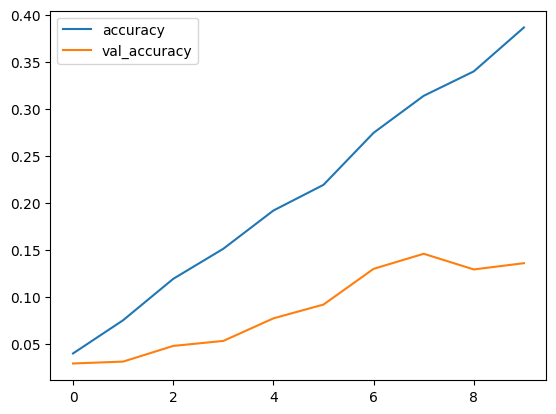

In [136]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()

In [159]:
train_preds = model.predict(train_ds)
train_preds = train_preds.argmax(axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 411ms/step


In [160]:
train_labels = np.array(train_labels)

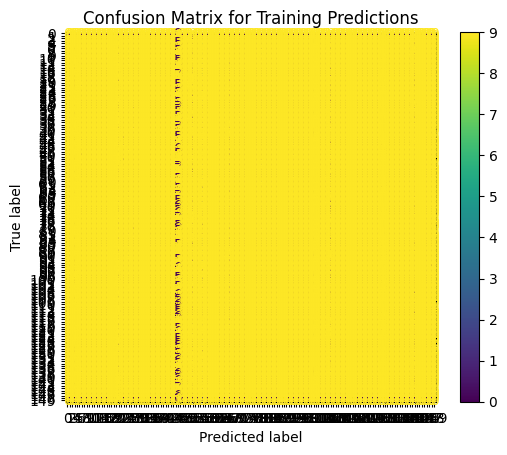

In [164]:
cm = confusion_matrix(train_labels, train_preds)
disp = ConfusionMatrixDisplay(cm)
disp.plot()
plt.title("Confusion Matrix for Training Predictions")
plt.show()

In [173]:
from collections import Counter

# Find misclassified instances
misclassified = [(true, pred) for true, pred in zip(train_preds, train_labels) if true != pred]

# Count most frequent misclassifications
misclass_counter = Counter(misclassified)
most_common_misclass = misclass_counter.most_common(10)

# Display most common misclassifications
for (true, pred), count in most_common_misclass:
    print(f"Class {true} misclassified as {pred}: {count} times")

Class 45 misclassified as 79: 9 times
Class 45 misclassified as 0: 8 times
Class 45 misclassified as 132: 7 times
Class 45 misclassified as 144: 7 times
Class 45 misclassified as 116: 7 times
Class 45 misclassified as 54: 7 times
Class 45 misclassified as 139: 7 times
Class 45 misclassified as 30: 7 times
Class 45 misclassified as 66: 7 times
Class 45 misclassified as 38: 7 times


In [129]:
print(model.evaluate(valid_ds))

47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.0168 - loss: 4.9767
[4.9540228843688965, 0.01733333244919777]


## Demonstration

In [130]:
SAMPLES_TO_DISPLAY = 10

test_ds = paths_and_labels_to_dataset(test_audio_paths, test_labels)
test_ds = test_ds.shuffle(buffer_size=BATCH_SIZE * 8, seed=SHUFFLE_SEED).batch(
    BATCH_SIZE
)

for audios, labels in test_ds.take(1):
    # Get the signal FFT
    ffts = audio_to_fft(audios)
    # Predict
    y_pred = model.predict(ffts)
    # Take random samples
    rnd = np.random.randint(0, BATCH_SIZE, SAMPLES_TO_DISPLAY)
    audios = audios.numpy()[rnd, :, :]
    labels = labels.numpy()[rnd]
    y_pred = np.argmax(y_pred, axis=-1)[rnd]

    for index in range(SAMPLES_TO_DISPLAY):
        # For every sample, print the true and predicted label
        # as well as run the voice with the noise
        print(
            "Speaker:\33{} {}\33[0m\tPredicted:\33{} {}\33[0m".format(
                "[92m" if labels[index] == y_pred[index] else "[91m",
                train_class_names[labels[index]],
                "[92m" if labels[index] == y_pred[index] else "[91m",
                train_class_names[y_pred[index]],
            )
        )
        display(Audio(audios[index, :, :].squeeze(), rate=SAMPLING_RATE))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step
Speaker: 120	Predicted: 64


/Users/danielhill/Documents/AdvancedMachineLearningFinal/.venv/lib/python3.12/site-packages/IPython/lib/display.py:187: RuntimeWarning: invalid value encountered in divide
  scaled = data / normalization_factor * 32767
/Users/danielhill/Documents/AdvancedMachineLearningFinal/.venv/lib/python3.12/site-packages/IPython/lib/display.py:188: RuntimeWarning: invalid value encountered in cast
  return scaled.astype("<h").tobytes(), nchan


Speaker: 29	Predicted: 59


Speaker: 78	Predicted: 17


Speaker: 134	Predicted: 64


Speaker: 38	Predicted: 64


Speaker: 47	Predicted: 59


Speaker: 55	Predicted: 64


Speaker: 123	Predicted: 94


Speaker: 29	Predicted: 94


Speaker: 30	Predicted: 94


2024-06-03 15:30:37.343885: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
